In [1]:
from bio_embeddings import SeqVecEmbedder
from pandas import read_excel, DataFrame

/Users/chdallago/miniconda3/envs/allennlp/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
embedder = SeqVecEmbedder(weights_file="../models/elmov1/weights.hdf5", options_file="../models/elmov1/options.json")

LOG: CUDA NOT available


In [3]:
data = read_excel('../private/antibodies.xls', index_col=0)
display(data[:2])

,VH,D,RF,JH,JH.1,HEAVY CDR3 (aa),HEAVY Length,Vk,Jk,CDR3DNA,LIGHT CDR3 (aa),LIGHT Length,Poly,Hep2,Staining
Ig,,,,,,,,,,,,,,,
neHD11 102,4-39,3-10,3,3,NaN,DGITMVRGPHDAFDI,15,3-15,1,NaN,QQYNNWPPTWT,11,-,-,-
neHD11 104,4-30-2,3-9,1,5,NaN,GGLYFDWPKGGWFDP,15,3-15,1,NaN,QQYNNWPWT,9,+,+,-


In [4]:
heavy_embeddings = [embedder.reduce_per_protein(embedding) for embedding in embedder.embed_many(data['HEAVY CDR3 (aa)'])]
ligth_embeddings = [embedder.reduce_per_protein(embedding) for embedding in embedder.embed_many(data['LIGHT CDR3 (aa)'])]

samples = list(zip(heavy_embeddings, ligth_embeddings, data['Poly']))

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

%matplotlib inline

In [6]:
merge = False

if merge:
    _data = [sample[0]+sample[1] for sample in samples]
else:
    _data = [np.concatenate([sample[0], sample[1]]) for sample in samples]

distance_matrix = pairwise_distances(_data, _data, metric='euclidean', n_jobs=-1)
transformed_embeddings = TSNE(n_components= 2,
                      perplexity  = 3,
                      random_state= 420,
                      n_iter      = 15000,
                      verbose     = 1,
                      metric      = 'precomputed'
                ).fit_transform(distance_matrix)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.404155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.005714
[t-SNE] KL divergence after 1500 iterations: 0.202267


In [7]:
embeddings_dataframe = DataFrame(transformed_embeddings, columns=["x", "y"])
embeddings_dataframe['label'] = [sample[2] for sample in samples]
embeddings_dataframe['label'] = embeddings_dataframe['label'].apply(lambda x: 0 if x == '-' else 1)

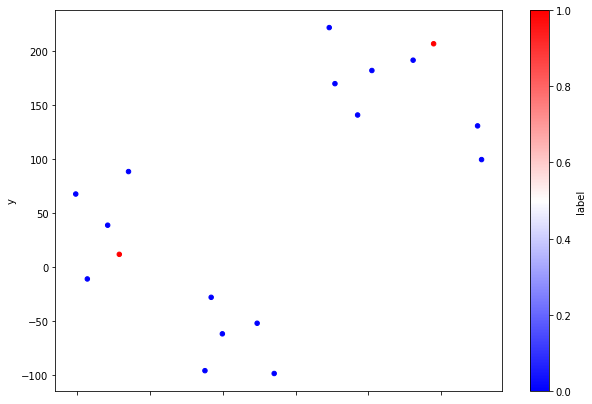

In [8]:
embeddings_dataframe.plot.scatter(x='x',y='y', c='label', colormap='bwr', figsize=(10,7), s=20)